In [232]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [233]:
%autoreload
import torch
import torch.nn as nn
import torchvision
import numpy as np
from gpt.model import ViT, Lambda, LightningWrapper
from gpt.data import MNISTDataModule, CIFAR10DataModule, Galaxy10DataModule, ImagenetH5DataModule
from tqdm.auto import tqdm
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from rich.progress import track
from einops.layers.torch import Rearrange
from einops import rearrange, repeat

In [234]:
# def collate(lop):
#     x, y = zip(*lop)
#     x = torch.stack(x)
#     return x.view(-1, *x.shape[1:]), torch.tensor(y).unsqueeze(-1).repeat(1, x.shape[1]).view(-1).long()

def collate(lop):
    x, y = zip(*lop)
    x = torch.stack(x)
    y = torch.tensor(y)
    print(x.shape)
    ncrops = x.shape[1]
    y = repeat(y, 'n -> n c', c=ncrops).ravel()
    x = rearrange(x, 'b n c h w -> (b n) c h w')
    return x, y

mnist = Galaxy10DataModule(root_dir='/scratch/gpfs/js5013/data/ml/', num_workers=1, batch_size=8, pin_memory=True)#, collate_fn_train=collate, extra_transforms=[transforms.FiveCrop(28), Lambda(torch.stack)])#, collate_fn=collate)
mnist.setup()

In [235]:
tl = mnist.test_dataloader()

In [236]:
x, y = next(iter(tl))

In [237]:
x.shape, y.shape

(torch.Size([8, 3, 64, 64]), torch.Size([8]))

In [238]:
model = LightningWrapper.load_from_checkpoint('../train/lightning_logs/version_1046912/checkpoints/epoch=11-step=29412.ckpt', map_location='cuda:0')
model.freeze()

/scratch/gpfs/js5013/.conda/envs/foundation/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'output_head' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_head'])`.


In [241]:
def show(imgs, **kwargs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = TF.to_pil_image(mnist.unnormalize(img))
        axs[0, i].imshow(np.asarray(img), **kwargs)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

(None, tensor([7, 2, 1, 9, 2, 4, 0, 0], dtype=torch.uint8))

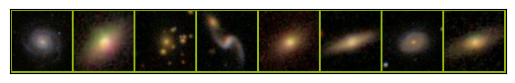

In [242]:
show(torchvision.utils.make_grid(x)), y# + torch.randn(x.shape) * torch.std(x, axis=(0, 2, 3), keepdim=True) * 0.0)), list(map(lambda i: mnist.classes[i], y))

In [243]:
torch.argmax(model(x.cuda(0)), axis=1)

tensor([1, 2, 1, 9, 2, 4, 0, 4], device='cuda:0')

In [244]:
score = 0
total = 0
for x, y in track(tl, total=len(tl)):
    with torch.no_grad():
        out = model(x.cuda(0))
        pred = torch.argmax(out, 1).cpu()
    score += torch.sum(pred == y)
    total += x.shape[0]

Output()

In [223]:
score / total

tensor(0.8744)

In [7]:
def collate(lop):
    x, _ = zip(*lop)
    x = torch.stack(x)
    return x

cifar = CIFAR10DataModule(batch_size=64, root_dir='/scratch/gpfs/js5013/data/ml/')#, collate_fn=collate)
cifar.setup()

In [8]:
tl = cifar.test_dataloader()

In [9]:
x, y = next(iter(tl))

In [10]:
x.shape

torch.Size([64, 3, 32, 32])

In [11]:
y.shape

torch.Size([64])